# Sample D-Fire images
This notebook surfaces two representative images for each label category (class 1 = fire, class 0 = smoke/other, and empty YOLO label files) from both the `train` and `test` splits of the D-Fire dataset.


The file names below were chosen after inspecting the YOLO label files.

* Class-specific samples only contain annotations for that class.
* "No label" samples correspond to empty label files, so no bounding boxes will be shown for them.
* Every cell includes lightweight assertions so the notebook fails fast if the dataset layout ever changes.
* Bounding boxes are rendered using the normalized YOLO coordinates to make the differences between the classes clear at a glance.


In [11]:

from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os


In [12]:

def resolve_data_root():
    candidates = [
        Path('D-Fire'),
        Path('fire-detection/D-Fire'),
        Path('../D-Fire')
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        'Could not locate the D-Fire dataset. Update `resolve_data_root` with the correct path.'
    )

DATA_ROOT = resolve_data_root()
CATEGORY_LABELS = {
    'class_1': 'Label 1 (fire)',
    'class_0': 'Label 0 (smoke/other)',
    'no_label': 'No label file entries'
}
CATEGORY_COLORS = {
    'class_1': 'red',
    'class_0': 'yellow'
}

SAMPLE_SELECTION = {
    'train': {
        'class_1': ['WEB05402.jpg', 'WEB04708.jpg'],
        'class_0': ['AoF05695.jpg', 'WEB08898.jpg'],
        'no_label': ['WEB01102.jpg', 'AoF00935.jpg']
    },
    'test': {
        'class_1': ['AoF07928.jpg', 'AoF07900.jpg'],
        'class_0': ['WEB11311.jpg', 'WEB11477.jpg'],
        'no_label': ['AoF07082.jpg', 'AoF07096.jpg']
    }
}

def parse_label_file(label_path):
    lines = []
    for raw_line in label_path.read_text().splitlines():
        raw_line = raw_line.strip()
        if not raw_line:
            continue
        parts = raw_line.split()
        cls = parts[0]
        coords = list(map(float, parts[1:5]))
        lines.append({'class': cls, 'coords': coords})
    return lines

def prepare_samples(selection):
    sample_details = {}
    for split, categories in selection.items():
        split_images = DATA_ROOT / split / 'images'
        split_labels = DATA_ROOT / split / 'labels'
        split_details = {}
        for category, filenames in categories.items():
            entries = []
            for filename in filenames:
                image_path = split_images / filename
                label_path = split_labels / f"{Path(filename).stem}.txt"
                assert image_path.exists(), f"Missing image: {image_path}"
                assert label_path.exists(), f"Missing label file: {label_path}"
                records = parse_label_file(label_path)
                tokens = [item['class'] for item in records]
                if category == 'no_label':
                    assert not tokens, f"{label_path} is expected to be empty"
                else:
                    expected = '1' if category == 'class_1' else '0'
                    assert tokens and set(tokens) == {expected}, (
                        f"Only class {expected} should appear in {label_path}", tokens
                    )
                entries.append({'image': image_path, 'label': label_path, 'records': records})
            split_details[category] = entries
        sample_details[split] = split_details
    return sample_details

sample_details = prepare_samples(SAMPLE_SELECTION)
summary = {
    split: {cat: [entry['image'].name for entry in entries]
            for cat, entries in categories.items()}
    for split, categories in sample_details.items()
}

pprint(summary)


{'test': {'class_0': ['WEB11311.jpg', 'WEB11477.jpg'],
          'class_1': ['AoF07928.jpg', 'AoF07900.jpg'],
          'no_label': ['AoF07082.jpg', 'AoF07096.jpg']},
 'train': {'class_0': ['AoF05695.jpg', 'WEB08898.jpg'],
           'class_1': ['WEB05402.jpg', 'WEB04708.jpg'],
           'no_label': ['WEB01102.jpg', 'AoF00935.jpg']}}


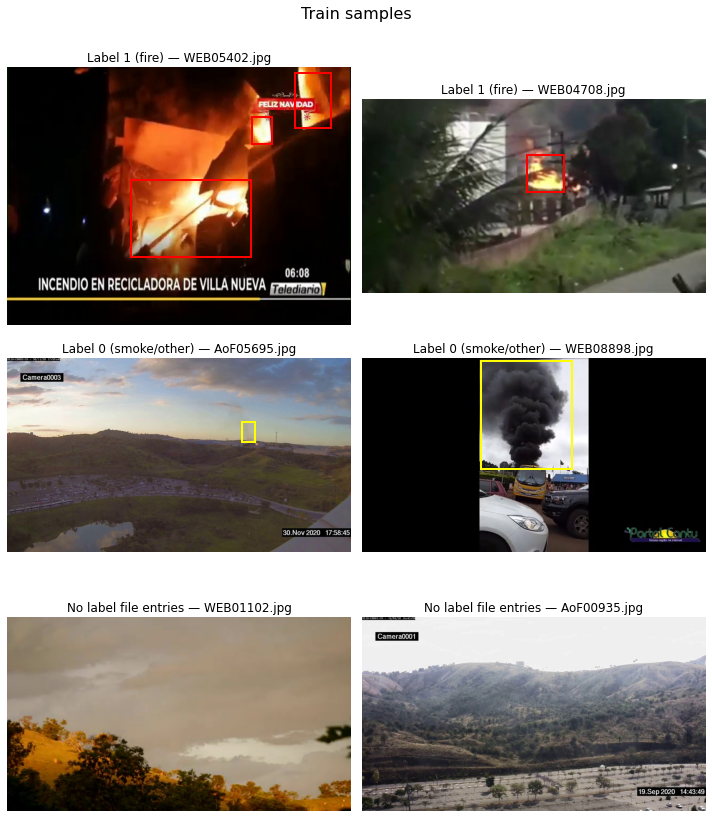

In [13]:

def yolo_to_rectangle(coords, image_shape):
    x_center, y_center, width_rel, height_rel = coords
    img_height, img_width = image_shape[0], image_shape[1]
    width = width_rel * img_width
    height = height_rel * img_height
    x_min = (x_center * img_width) - width / 2
    y_min = (y_center * img_height) - height / 2
    return x_min, y_min, width, height

def display_samples(split):
    categories = ['class_1', 'class_0', 'no_label']
    fig, axes = plt.subplots(len(categories), 2, figsize=(10, 12))
    for row, category in enumerate(categories):
        entries = sample_details[split][category]
        for col, entry in enumerate(entries):
            ax = axes[row, col]
            image = mpimg.imread(entry['image'])
            ax.imshow(image)
            ax.set_title(f"{CATEGORY_LABELS[category]} — {entry['image'].name}")
            ax.axis('off')
            if category != 'no_label':
                class_key = 'class_1' if category == 'class_1' else 'class_0'
                color = CATEGORY_COLORS[class_key]
                for rec in entry['records']:
                    x, y, w, h = yolo_to_rectangle(rec['coords'], image.shape)
                    rect = patches.Rectangle(
                        (x, y), w, h,
                        linewidth=2,
                        edgecolor=color,
                        facecolor='none'
                    )
                    ax.add_patch(rect)
    fig.suptitle(f"{split.title()} samples", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

display_samples('train')


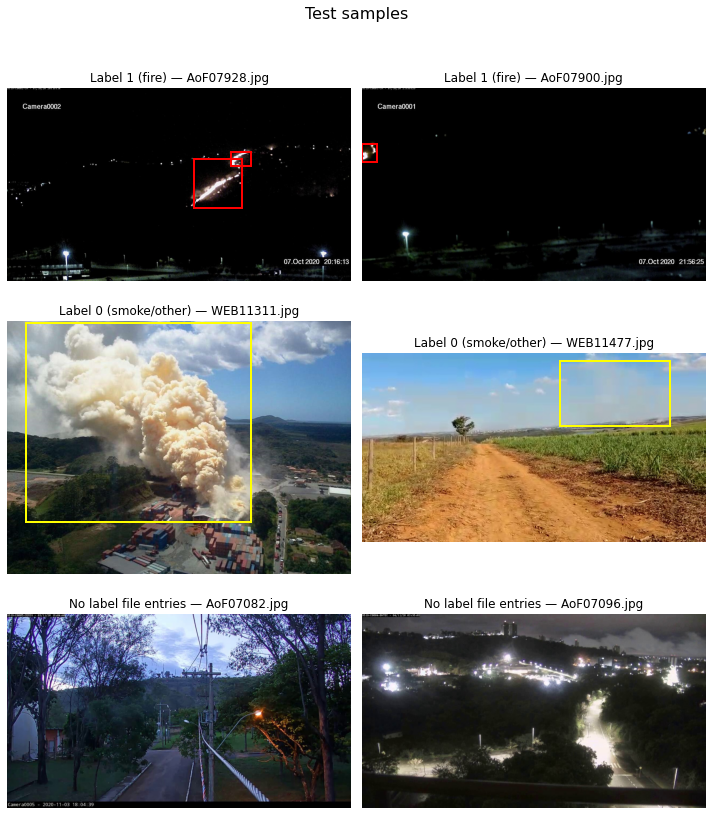

In [14]:

display_samples('test')


In [15]:
if os.path.exists("processed_dfire/"):
    for folder in os.listdir("processed_dfire/"):
        folder_path = os.path.join("processed_dfire/", folder)
        if os.path.isdir(folder_path):
            for class_name in os.listdir(folder_path):
                count = 0
                for image_file in os.listdir(os.path.join(folder_path, class_name)):
                    count += 1
                print(f"{folder}/{class_name}: {count} images")
            print()
                


In [18]:
# Find images with both fire (class 1) and smoke (class 0) labels (OPTIMIZED - stops at 3)
def find_images_with_both_labels():
    both_labels = []
    target_count = 3  # Stop after finding 3 images
    
    for split in ['train', 'test']:
        # Check if we already have enough
        if len(both_labels) >= target_count:
            break
            
        label_dir = DATA_ROOT / split / 'labels'
        if not label_dir.exists():
            continue
        
        # Get all label files first to show progress
        label_files = sorted(label_dir.glob('*.txt'))
        total = len(label_files)
        print(f"Scanning {split}: {total} label files...")
        
        for idx, label_file in enumerate(label_files):
            # Check if we already have enough
            if len(both_labels) >= target_count:
                break
                
            # Show progress every 100 files
            if idx > 0 and idx % 100 == 0:
                print(f"  Processed {idx}/{total} files...")
            
            # Quick check: read file and extract only class IDs (first token of each line)
            classes = set()
            try:
                with open(label_file, 'r') as f:
                    for line in f:
                        line = line.strip()
                        if line:
                            cls = line.split()[0]  # Only get class ID, ignore coordinates
                            classes.add(cls)
                            # Early exit: if we found both, stop reading
                            if '0' in classes and '1' in classes:
                                break
            except Exception as e:
                continue  # Skip malformed files
            
            if '0' in classes and '1' in classes:
                image_name = label_file.stem + '.jpg'
                image_path = DATA_ROOT / split / 'images' / image_name
                if image_path.exists():
                    # Only parse full records if we need them (for plotting later)
                    records = parse_label_file(label_file)
                    both_labels.append({
                        'split': split,
                        'image': image_path,
                        'label': label_file,
                        'records': records
                    })
                    print(f"  Found image {len(both_labels)}/{target_count}: {image_name}")
                    
                    # Stop if we've found enough
                    if len(both_labels) >= target_count:
                        break
        
        print(f"  {split} complete: found {sum(1 for img in both_labels if img['split'] == split)} images with both labels")
    
    return both_labels

both_label_images = find_images_with_both_labels()
print(f"\nTotal: Found {len(both_label_images)} images with both fire and smoke labels")
print(f"Train: {sum(1 for img in both_label_images if img['split'] == 'train')}")
print(f"Test: {sum(1 for img in both_label_images if img['split'] == 'test')}")

# Show first few filenames
for img in both_label_images[:10]:
    print(f"  {img['split']}: {img['image'].name}")

Scanning train: 17221 label files...
  Processed 100/17221 files...
  Processed 200/17221 files...
  Processed 300/17221 files...
  Processed 400/17221 files...
  Processed 500/17221 files...
  Processed 600/17221 files...
  Processed 700/17221 files...
  Processed 800/17221 files...
  Processed 900/17221 files...
  Processed 1000/17221 files...
  Processed 1100/17221 files...
  Processed 1200/17221 files...
  Processed 1300/17221 files...
  Processed 1400/17221 files...
  Processed 1500/17221 files...
  Processed 1600/17221 files...
  Processed 1700/17221 files...
  Processed 1800/17221 files...
  Processed 1900/17221 files...
  Processed 2000/17221 files...
  Processed 2100/17221 files...
  Processed 2200/17221 files...
  Processed 2300/17221 files...
  Processed 2400/17221 files...
  Processed 2500/17221 files...
  Processed 2600/17221 files...
  Processed 2700/17221 files...
  Processed 2800/17221 files...
  Processed 2900/17221 files...
  Processed 3000/17221 files...
  Processed 

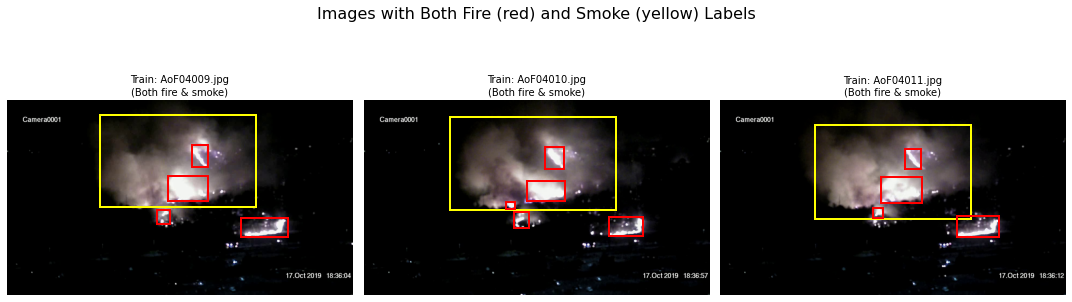

In [20]:
# Plot images with both fire and smoke labels
if both_label_images:
    # Select up to 6 images to display (3 from train, 3 from test)
    train_images = [img for img in both_label_images if img['split'] == 'train'][:3]
    test_images = [img for img in both_label_images if img['split'] == 'test'][:3]
    display_images = train_images + test_images
    
    if display_images:
        num_images = len(display_images)
        cols = 3
        rows = (num_images + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        
        # Ensure axes is always 2D for consistent indexing
        if rows == 1:
            axes = axes.reshape(1, -1)
        elif cols == 1:
            axes = axes.reshape(-1, 1)
        
        for idx, entry in enumerate(display_images):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col]
            
            image = mpimg.imread(entry['image'])
            ax.imshow(image)
            ax.set_title(f"{entry['split'].title()}: {entry['image'].name}\n(Both fire & smoke)", 
                        fontsize=10)
            ax.axis('off')
            
            # Draw bounding boxes with different colors for fire and smoke
            for rec in entry['records']:
                x, y, w, h = yolo_to_rectangle(rec['coords'], image.shape)
                color = 'red' if rec['class'] == '1' else 'yellow'
                label = 'fire' if rec['class'] == '1' else 'smoke'
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor=color,
                    facecolor='none',
                    label=label
                )
                ax.add_patch(rect)
        
        # Hide unused subplots
        for idx in range(num_images, rows * cols):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col]
            ax.axis('off')
        
        fig.suptitle('Images with Both Fire (red) and Smoke (yellow) Labels', fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
else:
    print("No images found with both fire and smoke labels")
